## Applicazione analisi Detection Histories e Modelli Occupancy

### Claudia Gabriela Ochoa Martinez (2020)

In [1]:
#### Inserire l'anno su cui si vuole effettuare l'analisi es. =="2014", "2015", ecc
anno_analisi <- "2018"
sessione_analisi <- "1"

In [2]:
library(dplyr)
library(readr)
library(unmarked)
require(stats4)
require(parallel)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: stats4


Attaching package: 'stats4'


The following object is masked from 'package:unmarked':

    mle


Loading required package: parallel



In [3]:
# Matrice di detection history (catture effettive) -- y
catture_effettive <- read.csv("Dati-preparazione-modello\\catture_effettive_totale.csv", dec=",", sep=";", header = TRUE)

# Leggiamo le matrici dell'Orario (Alba Tramonto), Precipitazioni e Temperatura -- ObsCovs
orario_occasione <- read.csv("Dati-preparazione-modello\\orario_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
precipitazioni_occasione <- read.csv("Dati-preparazione-modello\\precipitazioni_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
temperatura_occasione <- read.csv("Dati-preparazione-modello\\temperatura_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

# Prendiamo Datioccas per legare l'anno alle varie osservazioni
Datioccas <- read.csv("Dati-elaborati/Dati-occasioni.csv", dec=",", sep=";", header = TRUE)

# Leggiamo il file relativo alle invarianti ambientali (covariate) -- siteCovs
siteCovs <- read.csv("Dati-preparazione-modello/Dati-cov-mdr-iqr.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

In [4]:
# TRASFORMIAMO le specie vegetali presenti in siteCovs in numeric
siteCovs$dominant[siteCovs$dominant != "Graminacee" & siteCovs$dominant != "Muschio"]  <- 30
siteCovs$dominant[siteCovs$dominant == "Graminacee"]  <- 20
siteCovs$dominant[siteCovs$dominant == "Muschio"]  <- 10
siteCovs$dominant <- as.numeric(siteCovs$dominant)

# Seleziono la coperatura vegetale di interesse
if (anno_analisi %in% c("2014","2015","2016","2017")) {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2015_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))
} else {
    siteCovs$cop_veg_ottavi <- siteCovs$Cop_Veg_2018_ottavi
    siteCovs <- subset(siteCovs, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))

}
    
head(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,59,96,102,2782.206,234,13,23,20,96,21.5,-126,5
2,176,42,76,2781.136,294,16,16,20,76,67.0,-66,2
3,51,88,62,2781.067,310,0,13,20,62,18.5,-50,2
4,99,30,36,2781.087,293,8,23,20,36,34.5,-67,5
5,164,41,47,2781.887,294,11,21,20,47,61.5,-66,2
6,130,31,36,2782.237,310,7,20,20,36,49.5,-50,4


In [5]:
# Ricaviamo le colonne oggetto di analisi
if (exists("sessione_analisi")) {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi & sessione == sessione_analisi))
} else {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi))
}
colonne_oggetto_analisi <- as.numeric(colonne_oggetto_analisi)

In [6]:
catture_effettive_selezionate <- catture_effettive[,colonne_oggetto_analisi]

In [7]:
summary(siteCovs)

 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   : 30.0          Min.   : 28.00         Min.   :  8.00        
 1st Qu.: 65.0          1st Qu.: 44.00         1st Qu.: 40.00        
 Median : 97.0          Median : 61.00         Median : 57.00        
 Mean   :113.8          Mean   : 74.61         Mean   : 78.11        
 3rd Qu.:135.0          3rd Qu.: 92.00         3rd Qu.: 82.50        
 Max.   :440.0          Max.   :308.00         Max.   :292.00        
                                                                     
     alt_m        aspect_deg      slope_degr      n_species        dominant    
 Min.   :2778   Min.   :  0.0   Min.   : 0.00   Min.   : 0.00   Min.   :10.00  
 1st Qu.:2783   1st Qu.: 36.0   1st Qu.: 8.00   1st Qu.:10.00   1st Qu.:20.00  
 Median :2789   Median :310.0   Median :12.00   Median :14.00   Median :20.00  
 Mean   :2789   Mean   :225.3   Mean   :13.27   Mean   :15.15   Mean   :20.53  
 3rd Qu.:2795   3rd Qu.:330.5   3rd Qu.:

#### Concludiamo che tutte le variabili presenti in siteCovs sono adatte ad essere utilizzate nell'analisi
#### Provvediamo a scalarle e centrarle

In [8]:
siteCovs <- data.frame(scale(siteCovs))

In [9]:
summary(t(orario_occasione[1,colonne_oggetto_analisi]))
summary(t(precipitazioni_occasione[1,colonne_oggetto_analisi]))
summary(t(temperatura_occasione[1,colonne_oggetto_analisi]))


  1     
 Al:10  
 Tr: 9  

       1          
 Min.   :0.00000  
 1st Qu.:0.00000  
 Median :0.00000  
 Mean   :0.05263  
 3rd Qu.:0.00000  
 Max.   :1.00000  

       1        
 Min.   : 8.50  
 1st Qu.:12.35  
 Median :13.60  
 Mean   :13.59  
 3rd Qu.:15.15  
 Max.   :17.40  

#### La variabile relativa alle precipitazioni, nel 2015, è inadatta alle analisi, verrà automaticamente scartata dal modello
#### Le variabili categoriche non possono essere scalate (orario_ooccasione)
#### La variabile temperatura_occasione è inadatta ad essere scalata

In [10]:
obsCovs <- list(
    orario = orario_occasione[,colonne_oggetto_analisi],
    precip = precipitazioni_occasione[,colonne_oggetto_analisi],
    temper = temperatura_occasione[,colonne_oggetto_analisi]
)


In [11]:
arvicole <- unmarkedFrameOccu(y = catture_effettive_selezionate, siteCovs = siteCovs, obsCovs = obsCovs)
summary(arvicole)

unmarkedFrame Object

75 sites
Maximum number of observations per site: 19 
Mean number of observations per site: 19 
Sites with at least one detection: 17 

Tabulation of y observations:
   0    1 
1396   29 

Site-level covariates:
 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   :-1.1249        Min.   :-1.0122        Min.   :-1.09284      
 1st Qu.:-0.6550        1st Qu.:-0.6648        1st Qu.:-0.59401      
 Median :-0.2254        Median :-0.2956        Median :-0.32902      
 Mean   : 0.0000        Mean   : 0.0000        Mean   : 0.00000      
 3rd Qu.: 0.2848        3rd Qu.: 0.3775        3rd Qu.: 0.06848      
 Max.   : 4.3795        Max.   : 5.0679        Max.   : 3.33421      
                                                                     
     alt_m            aspect_deg        slope_degr        n_species      
 Min.   :-1.53434   Min.   :-1.5857   Min.   :-1.5628   Min.   :-1.9922  
 1st Qu.:-0.91819   1st Qu.:-1.3323   1st Qu.:-0.6204   1s

In [12]:
fm.base <- occu(~orario+temper + MDR
            ~slope_degr + I(slope_degr^2) +
            MDR + I(MDR^2) +
            IQR + I(IQR^2) +
            Esp.tr + I(Esp.tr^2)+
            cop_veg_ottavi +
            n_species + I(n_species^2) +
            dominant,
            arvicole)
fm.base


Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"25 sites have been discarded because of missing data."



Call:
occu(formula = ~orario + temper + MDR ~ slope_degr + I(slope_degr^2) + 
    MDR + I(MDR^2) + IQR + I(IQR^2) + Esp.tr + I(Esp.tr^2) + 
    cop_veg_ottavi + n_species + I(n_species^2) + dominant, data = arvicole)

Occupancy:
                Estimate    SE        z P(>|z|)
(Intercept)       -1.997 167.1 -0.01195   0.990
slope_degr       -11.234 107.3 -0.10468   0.917
I(slope_degr^2)    1.618  84.6  0.01913   0.985
MDR               -3.972  51.5 -0.07718   0.938
I(MDR^2)         -21.473  65.7 -0.32670   0.744
IQR               -5.154  28.4 -0.18152   0.856
I(IQR^2)          -5.685 117.3 -0.04846   0.961
Esp.tr             2.654  54.8  0.04846   0.961
I(Esp.tr^2)       15.944 118.3  0.13483   0.893
cop_veg_ottavi   -15.163  57.9 -0.26188   0.793
n_species        -11.413  73.6 -0.15501   0.877
I(n_species^2)     1.935  33.7  0.05747   0.954
dominant           0.221  77.9  0.00283   0.998

Detection:
            Estimate     SE      z P(>|z|)
(Intercept)    0.164 1.0990  0.150  0.8811


In [13]:
#fm.base <- occu(~orario+temper 
#            ~Diametro.roccia.1..cm.+
 #           Diametro.roccia.2..cm.+
  #          Diametro.roccia.3..cm.+
   #         cop_veg_ottavi +
    #        slope_degr + I(slope_degr^2) +
     #       n_species + I(n_species^2) +
      #      dominant,
       #     arvicole)
#fm.base

In [14]:
######### INFORMATICA
clusterType <- if(length(find.package("snow", quiet = TRUE))) "SOCK" else "PSOCK"
clusterType
clust <- try(makeCluster(getOption("cl.cores", 2), type = clusterType))
clusterEvalQ(clust, library(unmarked))
clusterEvalQ(clust,library(MuMIn))
clusterExport(clust, "arvicole")
invisible(clusterCall(clust, "library", "stats4", character.only = TRUE))
library(MuMIn)
getAllTerms(fm.base)

[1] "SOCK"

[[1]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

[[1]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

[1] "p(MDR)"               "p(orario)"            "p(temper)"           
 [4] "psi(cop_veg_ottavi)"  "psi(dominant)"        "psi(Esp.tr)"         
 [7] "psi(I(Esp.tr^2))"     "psi(IQR)"             "psi(I(IQR^2))"       
[10] "psi(MDR)"             "psi(I(MDR^2))"        "psi(n_species)"      
[13] "psi(I(n_species^2))"  "psi(slope_degr)"      "psi(I(slope_degr^2))"
attr(,"intercept")
  p psi 
  1   1 
attr(,"interceptLabel")
[1] "p(Int)"   "psi(Int)"
attr(,"deps")
                     p(MDR) p(orario) p(temper) psi(cop_veg_ottavi)
p(MDR)                   NA     FALSE     FALSE               FALSE
p(orario)             FALSE        NA     FALSE               FALSE
p(temper)             FALSE     FALSE        NA               FALSE
psi(cop_veg_ottavi)   FALSE     FALSE     FALSE                  NA
psi(dominant)         FALSE     FALSE     FALSE               FALSE
psi(Esp.tr)           FALSE     FALSE     FALSE               FALSE
psi(I(Esp.tr^2))      FALSE     FALSE     FALSE               FALSE
psi(IQR)              FALSE     FALSE     FALSE               FALSE
psi(I(IQR^2))         FALSE     FALSE     FALSE               FALSE
psi(MDR)              FALSE     FALSE     FALSE               FALSE
psi(I(MDR^2))         FALSE     FALSE     FALSE               FALSE
psi(n_species)        FALSE     FALSE     FALSE               FALSE
psi(I(n_species^2))   FALSE     FALSE     FALSE               FALSE
psi(slope_degr)       FALSE     FALSE     FALSE               FALSE
psi(I(slope_degr^2))  FALSE     FALSE     FALSE               FALSE
                     psi(dominant) psi(Esp.tr) psi(I(Esp.tr^2)) psi(IQR)
p(MDR)                       FALSE       FALSE            FALSE    FALSE
p(orario)                    FALSE       FALSE            FALSE    FALSE
p(temper)                    FALSE       FALSE            FALSE    FALSE
psi(cop_veg_ottavi)          FALSE       FALSE            FALSE    FALSE
psi(dominant)                   NA       FALSE            FALSE    FALSE
psi(Esp.tr)                  FALSE          NA            FALSE    FALSE
psi(I(Esp.tr^2))             FALSE       FALSE               NA    FALSE
psi(IQR)                     FALSE       FALSE            FALSE       NA
psi(I(IQR^2))                FALSE       FALSE            FALSE    FALSE
psi(MDR)                     FALSE       FALSE            FALSE    FALSE
psi(I(MDR^2))                FALSE       FALSE            FALSE    FALSE
psi(n_species)               FALSE       FALSE            FALSE    FALSE
psi(I(n_species^2))          FALSE       FALSE            FALSE    FALSE
psi(slope_degr)              FALSE       FALSE            FALSE    FALSE
psi(I(slope_degr^2))         FALSE       FALSE            FALSE    FALSE
                     psi(I(IQR^2)) psi(MDR) psi(I(MDR^2)) psi(n_species)
p(MDR)                       FALSE    FALSE         FALSE          FALSE
p(orario)                    FALSE    FALSE         FALSE          FALSE
p(temper)                    FALSE    FALSE         FALSE          FALSE
psi(cop_veg_ottavi)          FALSE    FALSE         FALSE          FALSE
psi(dominant)                FALSE    FALSE         FALSE          FALSE
psi(Esp.tr)                  FALSE    FALSE         FALSE          FALSE
psi(I(Esp.tr^2))             FALSE    FALSE         FALSE          FALSE
psi(IQR)                     FALSE    FALSE         FALSE          FALSE
psi(I(IQR^2))                   NA    FALSE         FALSE          FALSE
psi(MDR)                     FALSE       NA         FALSE          FALSE
psi(I(MDR^2))                FALSE    FALSE            NA          FALSE
psi(n_species)               FALSE    FALSE         FALSE             NA
psi(I(n_species^2))          FALSE    FALSE         FALSE          FALSE
psi(slope_degr)              FALSE    FALSE         FALSE          FALSE
psi(I(slope_degr^2))         FALSE    FALSE         FALSE          FALSE
                     psi(I(n_species^2)) psi(slope_degr) psi(I(slope_degr^2))
p(MDR)                      

In [15]:
#pdd2 <- pdredge(fm.base, clust,
#                subset = (`psi(slope_degr)` | !`psi(I(slope_degr^2))`) &&
#                 (`psi(n_species)` | !`psi(I(n_species^2))`) &&
#                 `psi(dominant)`,               
#                trace = 2, m.lim = c(1,NA))

In [16]:
#save(pdd2, file="Dati-elaborati/pdd2.RData", compress=FALSE)
#load("Dati-elaborati/pdd2.RData")

In [17]:
pdd3 <- pdredge(fm.base, clust,
                subset = (`psi(slope_degr)` | !`psi(I(slope_degr^2))`) &&
                (`psi(n_species)` | ! `psi(I(n_species^2))`) &&
                (`psi(MDR)` | ! `psi(I(MDR^2))`)&&
                (`psi(IQR)` | ! `psi(I(IQR^2))`)&&
                (`psi(Esp.tr)` | ! `psi(I(Esp.tr^2))`)&&
                 `psi(cop_veg_ottavi)` &&
                # `p(MDR)` &&
                 `p(temper)` &&
                 `p(orario)` &&
                 `psi(dominant)`,
                trace = 2, m.lim = c(1,NA), rank = "AIC")
save(pdd3, file="Dati-elaborati/pdd3.RData", compress=FALSE)
load("Dati-elaborati/pdd3.RData")

Fixed terms are "p(Int)" and "psi(Int)"



  |======================================================================| 100%


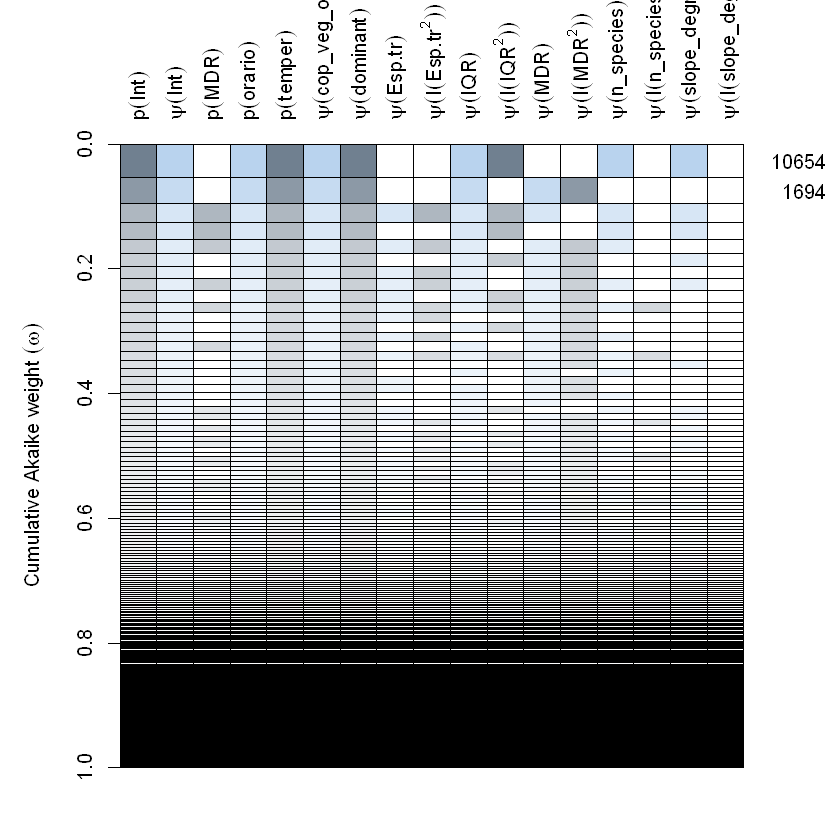

In [18]:
par(mfrow = c(1,1))
op <- par(mar = c(3,5,6,4), mfrow=c(1,1))
plot(pdd3, labAsExpr = TRUE)
par(op)


In [19]:
# riportare la tabella dei coefficienti
summary(get.models(pdd3, 1)[[1]])

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"25 sites have been discarded because of missing data."



Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + I(IQR^2) + n_species + slope_degr + 1, data = arvicole)

Occupancy (logit-scale):
               Estimate    SE      z P(>|z|)
(Intercept)       35.62  78.3  0.455   0.649
cop_veg_ottavi  -118.27 359.1 -0.329   0.742
dominant          28.41  82.2  0.346   0.730
IQR                8.69  31.0  0.280   0.779
I(IQR^2)         -68.75 115.0 -0.598   0.550
n_species        -67.61 206.2 -0.328   0.743
slope_degr       -73.52 192.1 -0.383   0.702

Detection (logit-scale):
            Estimate     SE      z P(>|z|)
(Intercept)    0.221 1.0927  0.202   0.840
orarioTr       0.293 0.3976  0.737   0.461
temper        -0.236 0.0819 -2.878   0.004

AIC: 226.1434 
Number of sites: 50
ID of sites removed due to NA: 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
optim convergence code: 0
optim iterations: 99 
Bootstrap iterations: 0 



In [20]:
## PASSAGGIO DI MODEL AVERAGING: CONSIDERIAMO CONTEMPORANEAMENTE I MODELLI MIGLIORI CHE DIFFERISCONO TRA LORO
## DI POCO IN TERMINI DI AIC (deltaAIC < 2)
summary(model.avg(pdd3, subset = delta < 2))


Call:
model.avg(object = pdd3, subset = delta < 2)

Component model call: 
occu(formula = ~<7 unique rhs>, data = arvicole)

Component models: 
                           df  logLik    AIC delta weight
2/3/4/5/8/9/12/13          10 -103.07 226.14  0.00   0.25
2/3/4/5/8/10/11             9 -104.29 226.59  0.45   0.20
1/2/3/4/5/6/7/8/9/10/12/13 14  -99.65 227.29  1.15   0.14
1/2/3/4/5/8/9/12/13        11 -102.71 227.42  1.28   0.13
1/2/3/4/5/6/7/8/10/11/12   13 -100.94 227.88  1.74   0.10
2/3/4/5/8/9/10/11/13       11 -103.05 228.10  1.95   0.09
2/3/4/5/6/7/8/10/11        11 -103.07 228.14  2.00   0.09

Term codes: 
             p(MDR)           p(orario)           p(temper) psi(cop_veg_ottavi) 
                  1                   2                   3                   4 
      psi(dominant)         psi(Esp.tr)    psi(I(Esp.tr^2))            psi(IQR) 
                  5                   6                   7                   8 
      psi(I(IQR^2))            psi(MDR)       psi(I(M

In [21]:
best.mod1 <- (get.models(pdd3, 1)[[1]])
best.mod1

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"25 sites have been discarded because of missing data."



Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + I(IQR^2) + n_species + slope_degr + 1, data = arvicole)

Occupancy:
               Estimate    SE      z P(>|z|)
(Intercept)       35.62  78.3  0.455   0.649
cop_veg_ottavi  -118.27 359.1 -0.329   0.742
dominant          28.41  82.2  0.346   0.730
IQR                8.69  31.0  0.280   0.779
I(IQR^2)         -68.75 115.0 -0.598   0.550
n_species        -67.61 206.2 -0.328   0.743
slope_degr       -73.52 192.1 -0.383   0.702

Detection:
            Estimate     SE      z P(>|z|)
(Intercept)    0.221 1.0927  0.202   0.840
orarioTr       0.293 0.3976  0.737   0.461
temper        -0.236 0.0819 -2.878   0.004

AIC: 226.1434 

In [22]:
best.mod <- occu(~ MDR + temper
                 ~ MDR +
                   Esp.tr +
                   dominant,
                 arvicole)
best.mod

Warning message in (new("standardGeneric", .Data = function (object) :
"Model did not converge. Try providing starting values or increasing maxit control argment."



Call:
occu(formula = ~MDR + temper ~ MDR + Esp.tr + dominant, data = arvicole)

Occupancy:
            Estimate     SE      z P(>|z|)
(Intercept)    61.64  77.37  0.797   0.426
MDR           131.05 171.01  0.766   0.443
Esp.tr        -37.78  51.25 -0.737   0.461
dominant        1.54   2.68  0.574   0.566

Detection:
            Estimate    SE      z  P(>|z|)
(Intercept)   -0.289 1.010 -0.286 0.774529
MDR           -1.691 0.441 -3.838 0.000124
temper        -0.241 0.080 -3.019 0.002532

AIC: 245.5285 

,Predicted,SE,lower,upper,MDR,Esp.tr,dominant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,5.404132e-72,1.112157e-117,1,2.339564e-17,-2.814383,1
2,1,3.556965e-71,2.578496e-116,1,2.339564e-17,-2.764204,1
3,1,2.340856e-70,5.978007e-115,1,2.339564e-17,-2.714024,1
4,1,1.540316e-69,1.385911e-113,1,2.339564e-17,-2.663844,1
5,1,1.013406e-68,3.212941e-112,1,2.339564e-17,-2.613664,1
6,1,6.666443e-68,7.448320e-111,1,2.339564e-17,-2.563484,1


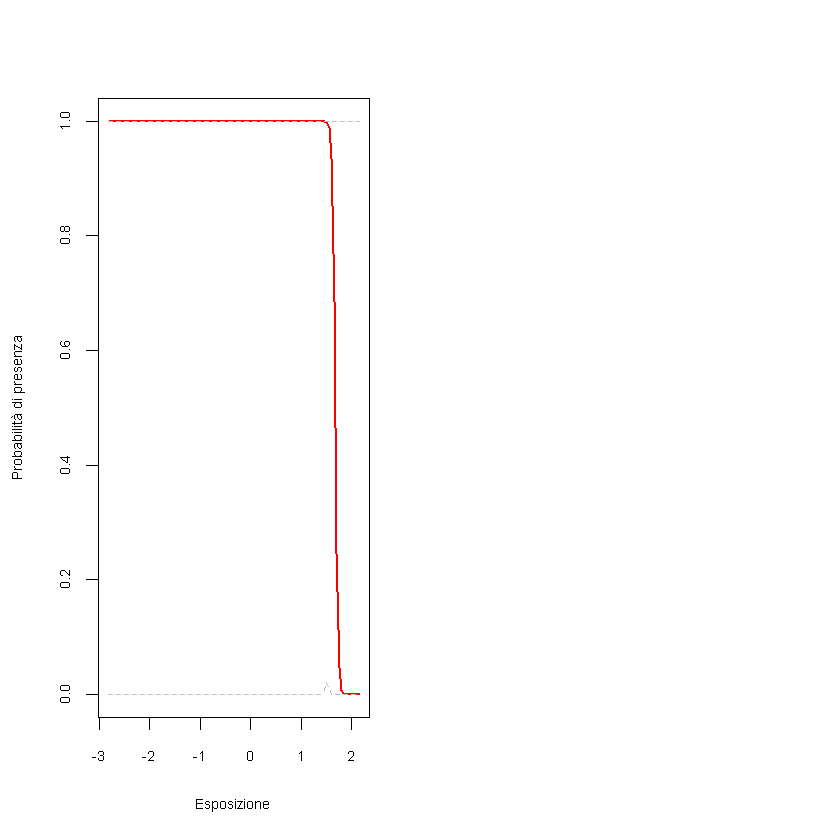

In [23]:
newdat1 <- data.frame(MDR = mean(siteCovs$MDR),
                     Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr), length=100),
                     dominant = "Graminacee")
newdat2 <- data.frame(MDR = mean(siteCovs$MDR),
                      Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr), length=100),
                      dominant = "Muschio")
newdat3 <- data.frame(MDR = mean(siteCovs$MDR),
                      Esp.tr = seq(min(siteCovs$Esp.tr), max(siteCovs$Esp.tr), length=100),
                      dominant = "Other_sp")
newdat <- rbind(newdat1,newdat2,newdat3)
newdat$dominant <- as.numeric(newdat$dominant)
Elambda <- predict(best.mod, type='state', newdata=newdat,
                   appendData=TRUE)
head(Elambda)
Elambda.logit <- Elambda

par(mfrow=c(1, 2))
with(subset(Elambda.logit,dominant=="1"), {
  plot(Esp.tr, Predicted, xlab="Esposizione", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
   lines(Esp.tr, upper, lty=2, col="grey")
  lines(Esp.tr, lower, lty=2, col="grey")
})

,Predicted,SE,lower,upper,MDR,Esp.tr,dominant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9.436588e-53,1.501229e-50,3.635433e-188,1,-1.396199,-1.362625e-17,1
2,1.727642e-49,2.579084e-47,1.469299e-176,1,-1.338873,-1.362625e-17,1
3,3.162951e-46,4.411720e-44,5.936602e-165,1,-1.281547,-1.362625e-17,1
4,5.790701e-43,7.509320e-41,2.397788e-153,1,-1.224221,-1.362625e-17,1
5,1.060156e-39,1.270883e-37,9.680343e-142,1,-1.166895,-1.362625e-17,1
6,1.940924e-36,2.136479e-34,3.905946e-130,1,-1.109569,-1.362625e-17,1


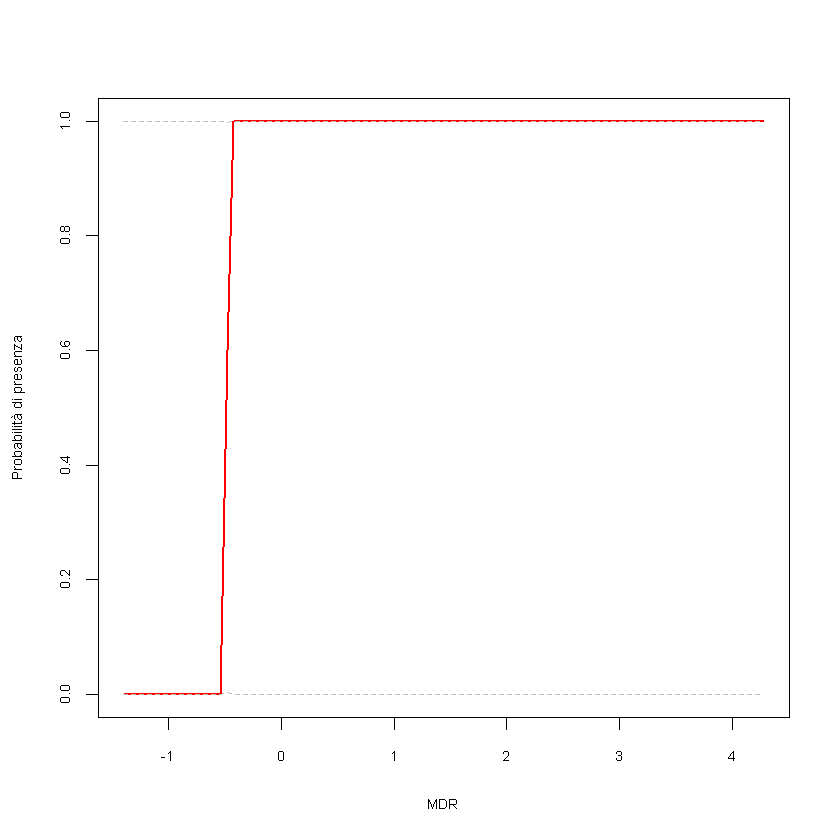

In [24]:
# Predict abundance at specified covariate values.
newdat_1 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      Esp.tr = mean(siteCovs$Esp.tr),
                      dominant = "Graminacee")
newdat_2 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      Esp.tr = mean(siteCovs$Esp.tr),
                      dominant = "Muschio")
newdat_3 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      Esp.tr = mean(siteCovs$Esp.tr),
                      dominant = "Other_sp")
newdata_ <- rbind(newdat_1,newdat_2,newdat_3)
newdata_$dominant <- as.numeric(newdata_$dominant)
Elambda_ <- predict(best.mod, type='state', newdata=newdata_,
                   appendData=TRUE)
head(Elambda_)
Elambda.logit <- Elambda_
with(subset(Elambda.logit,dominant=="1"), {
  plot(MDR, Predicted, xlab="MDR", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(MDR, Predicted+SE, lty=3, col="dark grey")
  # lines(MDR, Predicted-SE, lty=3, col="dark grey")
  lines(MDR, upper, lty=2, col="grey")
  lines(MDR, lower, lty=2, col="grey")
})

In [25]:
#calcolo media temp
maxt <- max(temperatura_occasione[,colonne_oggetto_analisi])
mint <- min(temperatura_occasione[,colonne_oggetto_analisi])
mean(maxt,mint)

[1] 17.4

,Predicted,SE,lower,upper,MDR,temper
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.10621326,0.06539042,0.02988473,0.3143265,-1.396199,17.4
2,0.09735719,0.05885730,0.02820523,0.2861323,-1.338873,17.4
3,0.08916587,0.05288090,0.02659612,0.2596687,-1.281547,17.4
4,0.08160144,0.04743443,0.02505444,0.2350093,-1.224221,17.4
5,0.07462616,0.04248851,0.02357741,0.2121847,-1.166895,17.4
6,0.06820285,0.03801212,0.02216234,0.1911881,-1.109569,17.4


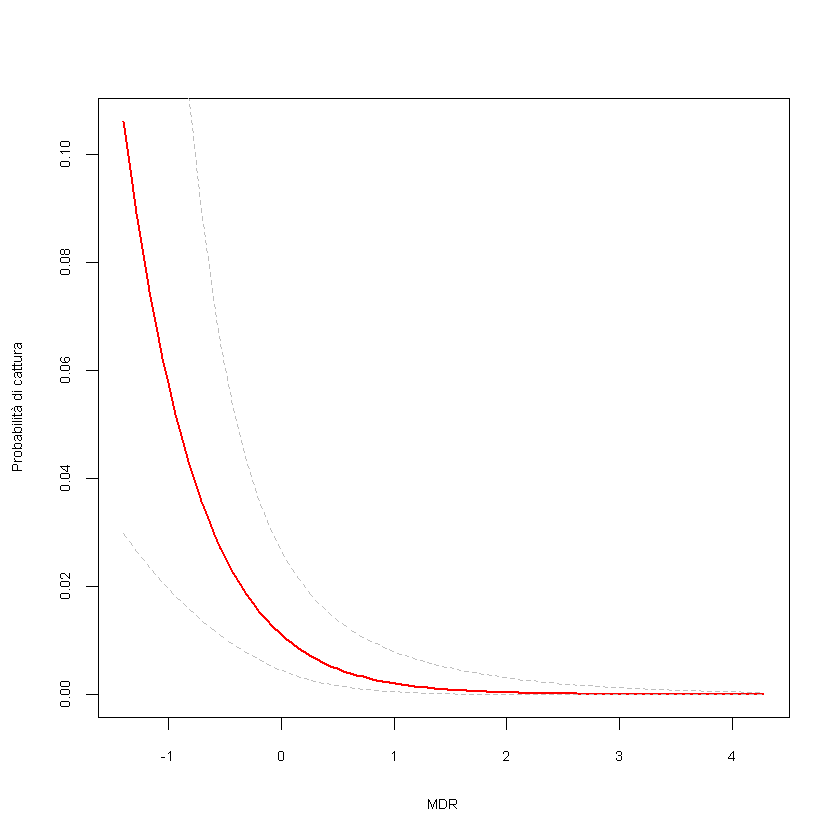

In [26]:
newdata1 <- data.frame(MDR = seq(min(siteCovs$MDR), max(siteCovs$MDR), length=100),
                      temper = mean(maxt,mint))
Elambda.det <- predict(best.mod, type='det', newdata=newdata1,
                   appendData=TRUE)
head(Elambda.det)
with(Elambda.det, {
  plot(MDR, Predicted, xlab="MDR", type="l", # names = habitat,
       ylab="Probabilità di cattura", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  # lines(MDR, Predicted+SE, lty=3, col="dark grey")
  # lines(MDR, Predicted-SE, lty=3, col="dark grey")
  lines(MDR, upper, lty=2, col="grey")
  lines(MDR, lower, lty=2, col="grey")
})

#### Applichiamo i modelli migliori

In [28]:
best.mod <- (get.models(pdd3, 1)[[1]])

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"25 sites have been discarded because of missing data."



Call:
occu(formula = ~orario + temper + 1 ~ cop_veg_ottavi + dominant + 
    IQR + I(IQR^2) + n_species + slope_degr + 1, data = arvicole)

Occupancy:
               Estimate    SE      z P(>|z|)
(Intercept)       35.62  78.3  0.455   0.649
cop_veg_ottavi  -118.27 359.1 -0.329   0.742
dominant          28.41  82.2  0.346   0.730
IQR                8.69  31.0  0.280   0.779
I(IQR^2)         -68.75 115.0 -0.598   0.550
n_species        -67.61 206.2 -0.328   0.743
slope_degr       -73.52 192.1 -0.383   0.702

Detection:
            Estimate     SE      z P(>|z|)
(Intercept)    0.221 1.0927  0.202   0.840
orarioTr       0.293 0.3976  0.737   0.461
temper        -0.236 0.0819 -2.878   0.004

AIC: 226.1434 

In [29]:
newdat1_1 <- data.frame(n_species = mean(siteCovs$n_species),
                     cop_veg_ottavi = seq(-1.433279, 2.485843, length=100),
                     slope_degr = mean(siteCovs$slope_degr),
                     dominant = "Graminacee")
newdat2_2 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = seq(-1.433279, 2.485843, length=100),
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Muschio")
newdat3_3 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = seq(-1.433279, 2.485843, length=100),
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Other_sp")
new_data <- rbind(newdat1_1,newdat2_2,newdat3_3)

In [30]:
Elmbd <- predict(best.mod, type='state', newdata=newd,
                   appendData=TRUE)
par(mfrow=c(1, 3))
with(subset(Elambda.logit,dominante=="Graminacee"), {
  plot(ott, Predicted, xlab="Copertura vegetazionale", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  lines(ott, upper, lty=2, col="grey")
  lines(ott, lower, lty=2, col="grey")
})


ERROR: Error in .local(object, ...): oggetto "newd" non trovato


In [ ]:
# Predict abundance at specified covariate values.
new_dat1 <- data.frame(n_species = seq(0, 32, length=100),
                      cop_veg_ottavi = 0,
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Graminacee")
new_dat2 <- data.frame(n_species = seq(0, 32, length=100),
                      cop_veg_ottavi = 0,
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Muschio")
new_dat3 <- data.frame(n_species = seq(0, 32, length=100),
                      cop_veg_ottavi = 0,
                      slope_degr = mean(siteCovs$slope_degr),
                      dominant = "Other_sp")
new_dat <- rbind(new_dat1,new_dat2,new_dat3)
elambda <- predict(best.mod, type='state', newdata=new_dat,
                   appendData=TRUE)
head(elambda)
Elambda.logit <- elambda
with(subset(Elambda.logit,dominant=="Graminacee"), {
  plot(n_species, Predicted, xlab="Numero di specie vegetali", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
       cex.lab=0.7, cex.axis=0.7, lwd=2, col="red")
  lines(n_species, upper, lty=2, col="grey")
  lines(n_species, lower, lty=2, col="grey")
})

In [ ]:
# Predict abundance at specified covariate values.
newdati1 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = 0,
                      slope_degr = seq(min(siteCovs$slope_degr),max(siteCovs$slope_degr), lenght=100),
                      dominant = "Graminacee")
newdati2 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = 0,
                      slope_degr = seq(min(siteCovs$slope_degr),max(siteCovs$slope_degr), lenght=100),
                      dominant = "Muschio")
newdati3 <- data.frame(n_species = mean(siteCovs$n_species),
                      cop_veg_ottavi = 0,
                      slope_degr = seq(min(siteCovs$slope_degr),max(siteCovs$slope_degr), lenght=100),
                      dominant = "Other_sp")
newdati_ <- rbind(newdati1,newdati2,newdati3)
elambda_ <- predict(best.mod, type='state', newdata=newdati_,
                   appendData=TRUE)
head(elambda_)
Elambda.logit <- elambda_
with(subset(Elambda.logit,dominant=="Graminacee"), {
  plot(slope_degr, Predicted, xlab="Inclinazione", type="l", # names = habitat,
       ylab="Probabilità di presenza", #ylim=c(-20, 40), # cex.names=0.7,
  lines(slope_degr, upper, lty=2, col="grey")
  lines(slope_degr, lower, lty=2, col="grey")
})

